In [6]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2],
                    triangles=face.t(), antialiased=False)
    plt.show()
    
def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
            src = pos[src].tolist()
            dst = pos[dst].tolist()
            plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
        mask = torch.zeros(pos.size(0), dtype=torch.bool)
        mask[index] = True
        plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
        plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

GeometricShapes(40)
Data(pos=[32, 3], face=[3, 30], y=[1])


/tmp/ipykernel_294093/4293402942.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


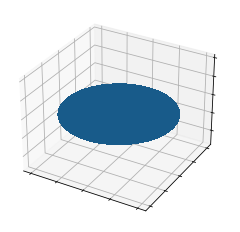

In [12]:
from torch_geometric.datasets import GeometricShapes
dataset = GeometricShapes(root="./data/GeometricShapes")
print(dataset)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

Data(pos=[256, 3], y=[1])


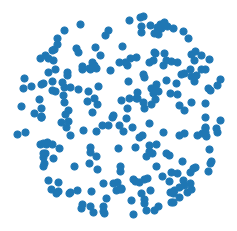

In [15]:
import torch
from torch_geometric.transforms import SamplePoints

dataset.transform = SamplePoints(num=256)

data = dataset[0]
print(data)
visualize_points(data.pos, data.edge_index)

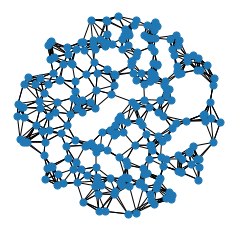

In [20]:
from torch_cluster import knn_graph

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6)
visualize_points(data.pos, edge_index=data.edge_index)

In [22]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import MessagePassing

class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation
        super().__init__(aggr='max')
        # Initialization of the MLP
        self.mlp = Sequential(Linear(in_channels+3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
    
    def forward(self, h, pos, edge_index):
        return self.propagate(edge_index, h=h, pos=pos)
    
    def message(self, h_j, pos_j, pos_i):
        input = pos_j - pos_i # Compute spatial relation
        if h_j is not None:
            input = torch.cat([h_j, input], dim=-1)
        
        return self.mlp(input)
    
class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)
        
    def forward(self, pos, edge_index, batch):
        if edge_index is None:
            edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
            
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()
        
        # global pooling
        h = global_max_pool(h, batch)
        
        return self.classifier(h)

model = PointNet()
print(model)
        

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)
